In [68]:
import numpy as np
import scipy.io as sio
import h5py
import tensorflow as tf
import pickle
import os
from matplotlib import pyplot as plt
import importlib
import inspect
from copy import deepcopy
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# root directory
if os.getcwd().find('/Users/svnh2') != -1:
    root_directory = '/Users/svnh2/Desktop/projects'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/home/svnh') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
elif os.getcwd().find('/mindhive/nklab3') != -1:
    root_directory = '/mindhive/nklab/u/svnh'
else:
    raise NameError('No root directory found')
    
# external repositories that depend on the root directory
# reload, in case they've changed
import sys
sys.path.append(root_directory)
from general_analysis import misc

Import CNN code, reset the graph

In [69]:
import cnn2d
importlib.reload(cnn2d)
tf.reset_default_graph()

Create some random features for input to CNN

In [38]:
# features
n_freqs = 30
n_feats = 1
n_stim = 300
n_tps_per_stim = 100
feat_dims = [n_stim, n_tps_per_stim, n_freqs, n_feats]
sr_Hz = 100
F = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2], feat_dims[3])

Create a random 2-layer network and sample from it

In [59]:
layers = []

# convolutional layer
layer = {}
layer['type'] = 'conv2d'
layer['time_win_sec'] = 0.1
layer['freq_win_smp'] = 5
layer['act'] = 'relu'
layer['n_kern'] = 1
layer['rank'] = None
layers.append(layer)

# output layer
layer = {}
layer['type'] = 'conv1d'
layer['time_win_sec'] = 0.1
layer['freq_win_smp'] = 5
layer['act'] = 'relu'
layer['n_kern'] = 100
layer['rank'] = None
layers.append(layer)

# # pooling/reweighting layer
# layer = {}
# layer['type'] = 'reweight-positive'
# layer['time_win_sec'] = 0.2
# layer['act'] = 'identity'
# layer['n_kern'] = 100
# layer['rank'] = None
# layers.append(layer)

# create network
net1_seed = 2
n_resp = 100
data_dims = [n_stim, n_tps_per_stim, n_resp]
tf.reset_default_graph()
net1 = cnn2d.Net(data_dims, n_freqs, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed)
net1.build()
D = net1.predict(F)

(?, 110, 30, 1)
(10, 30, 1, 100)
(?, 110, 30)
(10, 30, 100)
(?, 100, 1, 100)


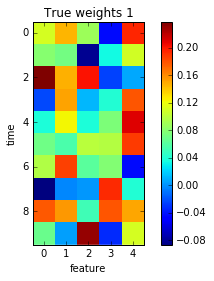

In [67]:
# True STRFs
net1_layer_vals = net1.layer_vals()
plt.imshow(net1_layer_vals[0]['W'][:,:,0,0], interpolation='none')
plt.ylabel('time'); plt.xlabel('feature')
plt.title('True weights 1')
plt.colorbar()
plt.show()
# plt.imshow(net1_layer_vals[0]['W'][:,:,0,1], interpolation='none')
# plt.ylabel('time'); plt.xlabel('feature')
# plt.title('True weights 2')
# plt.show()

Create a second network, and try to fit to the data from the first

In [61]:
# initialize second network
net2_seed = net1_seed+1
net2 = cnn2d.Net(data_dims, n_freqs, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed, weight_scale=0.001)
net2.build()

# train
n_train = np.int32(np.round(n_stim*0.6))
n_val = np.int32(np.round(n_stim*0.2))
n_test = n_stim - n_train - n_val
train_val_test = np.concatenate((np.zeros(n_train), np.ones(n_val), np.ones(n_test)*2), 0)
early_stopping_steps = 5 # 0 implies no early stopping
net2.train(F, D, max_iter=1000, eval_interval=30, learning_rate=0.01, 
           batch_size=10, train_val_test=train_val_test, 
           early_stopping_steps=early_stopping_steps)

(?, 110, 30, 1)
(10, 30, 1, 100)
(?, 110, 30)
(10, 30, 100)
(?, 100, 1, 100)
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
INFO:tensorflow:Restoring parameters from /Users/svnh2/Desktop/projects/scratch/seed3-model.ckpt


Plots illustrating results

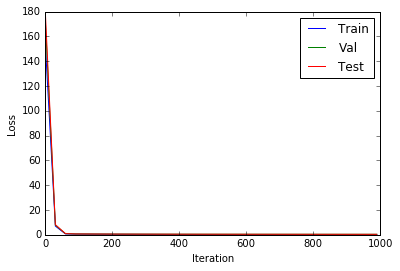

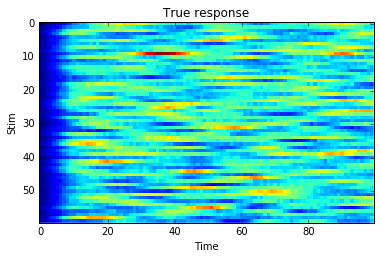

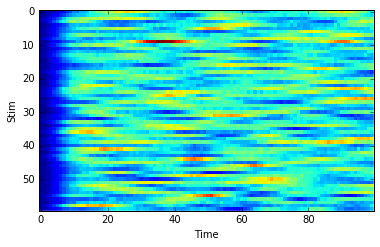

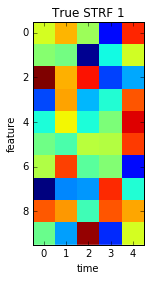

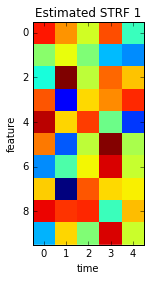

IndexError: index 1 is out of bounds for axis 3 with size 1

In [63]:
# loss
start_iter = 0
plt.plot(net2.iteration[start_iter:], net2.train_loss[start_iter:])
plt.plot(net2.iteration[start_iter:], net2.val_loss[start_iter:])
plt.plot(net2.iteration[start_iter:], net2.test_loss[start_iter:])
plt.legend(['Train', 'Val', 'Test'], loc='upper right')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.show()

# true and estimated response (first response)
q = 1
D_test = net1.predict(F[train_val_test==2,
                        :,:])
plt.imshow(D_test[:,:,q], interpolation='none')
plt.title('True response')
plt.ylabel('Stim'); plt.xlabel('Time')
plt.show()
D_test_estimated = net2.predict(F[train_val_test==2,:,:])
plt.imshow(D_test_estimated[:,:,q], interpolation='none')
plt.ylabel('Stim'); plt.xlabel('Time')
plt.show('Estimated response')
plt.show()

# true and estimated STRFs (layer 1)
net1_layer_vals = net1.layer_vals()
net2_layer_vals = net2.layer_vals()
plt.imshow(net1_layer_vals[0]['W'][:,:,0,0], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('True STRF 1')
plt.show()
# plt.imshow(net1_layer_vals[0]['W'][:,:,0,1], interpolation='none')
# plt.xlabel('time'); plt.ylabel('feature')
# plt.title('True STRF 2')
# plt.show()
plt.imshow(net2_layer_vals[0]['W'][:,:,0,0], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('Estimated STRF 1')
plt.show()
plt.imshow(net2_layer_vals[0]['W'][:,:,0,1], interpolation='none')
plt.xlabel('time'); plt.ylabel('feature')
plt.title('Estimated STRF 2')
plt.show()

# # true and estimated pooling weights
# plt.plot(net1_layer_vals[1]['W'][0,:,:].transpose())
# plt.title('True Weights')
# plt.show()
# plt.plot(net2_layer_vals[1]['W'][0,:,:].transpose())
# plt.title('Estimated Weights')
# plt.show()

Same as above, but with two features and two networks trained with different weights. Useful when you want to predict responses from two different feature sets. 

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990


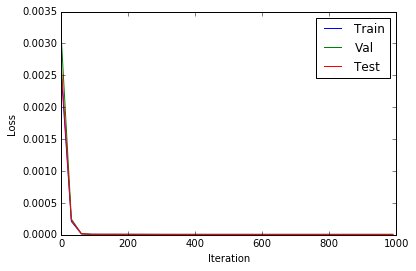

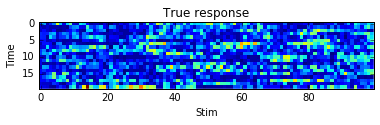

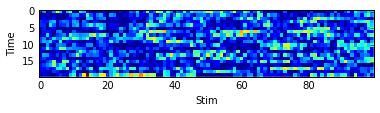

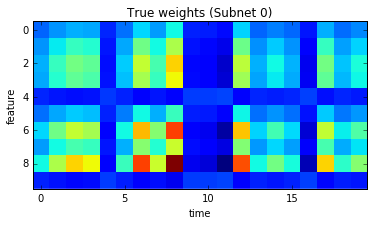

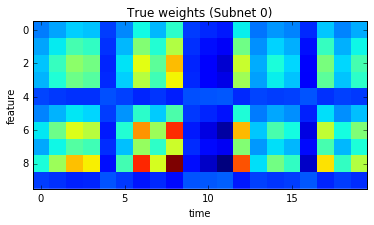

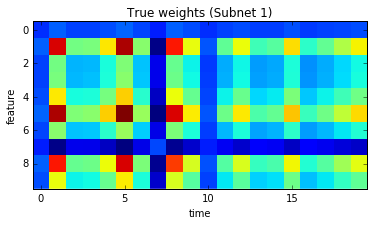

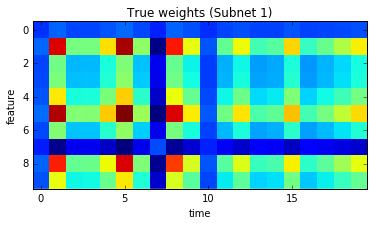

In [265]:
# two sets of features
F1 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])
F2 = np.random.randn(feat_dims[0], feat_dims[1], feat_dims[2])

# create features and data
net1_seed = 0
net1_1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed)
net1_2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net1_seed+1) 
multi_net1 = cnn.MultiNet([net1_1, net1_2])
multi_net1.build()
D = multi_net1.predict([F1, F2])

# new multi net
net2_seed = net1_seed + 10
net2_1 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed, weight_scale=0.001)
net2_2 = cnn.Net(data_dims, n_feats, sr_Hz, deepcopy(layers), seed=net2_seed+1, weight_scale=0.001)
multi_net2 = cnn.MultiNet([net2_1, net2_2])
multi_net2.build()

# train
n_train = np.int32(np.round(n_stim*0.6))
n_val = np.int32(np.round(n_stim*0.2))
n_test = n_stim - n_train - n_val
train_val_test = np.concatenate((np.zeros(n_train), np.ones(n_val), np.ones(n_test)*2), 0)
early_stopping_steps = 0 # 0 implies no early stopping
multi_net2.train([F1, F2], D, max_iter=1000, eval_interval=30, learning_rate=0.01, 
           batch_size=10, train_val_test=train_val_test, 
           early_stopping_steps=early_stopping_steps)

# loss
start_iter = 0
plt.plot(multi_net2.iteration[start_iter:], multi_net2.train_loss[start_iter:])
plt.plot(multi_net2.iteration[start_iter:], multi_net2.val_loss[start_iter:])
plt.plot(multi_net2.iteration[start_iter:], multi_net2.test_loss[start_iter:])
plt.legend(['Train', 'Val', 'Test'], loc='upper right')
plt.xlabel('Iteration'); plt.ylabel('Loss')
plt.show()

# true and estimated response (first response)
F_test = [F1[train_val_test==2,:,:], F2[train_val_test==2,:,:]]
D_test = multi_net1.predict(F_test)
plt.imshow(D_test[:,:,0], interpolation='none')
plt.title('True response')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show()
D_test_estimated = multi_net2.predict(F_test)
plt.imshow(D_test_estimated[:,:,0], interpolation='none')
plt.xlabel('Stim'); plt.ylabel('Time')
plt.show('Estimated response')
plt.show()

# true and estimated weights (first layer)
for i in range(2):
    multi_net1_layer_vals = multi_net1.layer_vals()
    multi_net2_layer_vals = multi_net2.layer_vals()
    plt.imshow(multi_net1_layer_vals[i][0]['W'][:,:,0], interpolation='none')
    plt.xlabel('time'); plt.ylabel('feature')
    plt.title('True weights (Subnet ' + str(i) + ')')
    plt.show()
    plt.imshow(multi_net2_layer_vals[i][0]['W'][:,:,0], interpolation='none')
    plt.xlabel('time'); plt.ylabel('feature')
    plt.title('True weights (Subnet ' + str(i) + ')')
    plt.show()

In [74]:
a = tf.placeholder('float32', shape=[None,3,4])
b = tf.reshape(a, [-1,3,4])

b
# a
# tf.reshape?
# a.shape[0]*a.shape[2]

<tf.Tensor 'Reshape_10:0' shape=(?, 3, 4) dtype=float32>

In [49]:
tf.reshape?